In [1]:
import sys
import os

# add project root to path
root = os.path.abspath("..")   # one level up from notebooks/
sys.path.append(root)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.utils import load_prices, realized_variance
from src.analysis import get_sim_logreturns, summarize_returns, qq_plot, get_var, get_es

In [ ]:
""" compute simulated log-returns for all models """

prices = load_prices("../data/SPY.csv", price_col="Price")

log_ret_gbm    = get_sim_logreturns("GBM",    prices, T=1.0, dt=1/252, n_paths=2000, seed=42)
log_ret_ou     = get_sim_logreturns("OU",     prices, T=1.0, dt=1/252, n_paths=2000, seed=42)
log_ret_heston = get_sim_logreturns("Heston", prices, T=1.0, dt=1/252, n_paths=2000, seed=42)
log_ret_merton = get_sim_logreturns("Merton", prices, T=1.0, dt=1/252, n_paths=2000, seed=42)

In [ ]:
""" extract real log-returns from price data """

_, log_returns = realized_variance(prices)
log_returns_lastyear = log_returns[-252:] # if using only a part of data (e.g. last years)

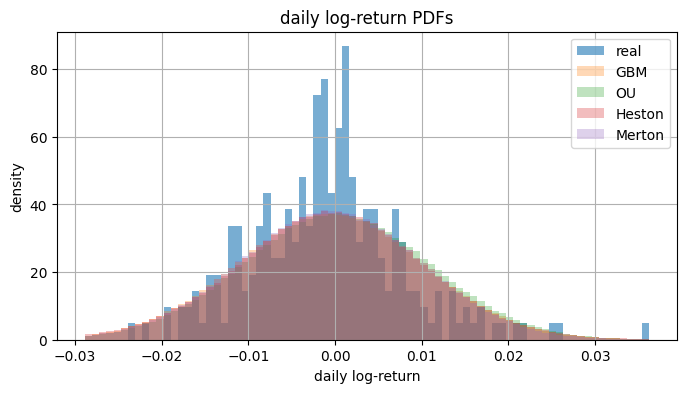

In [5]:
""" compare simulated log-returns from all models with observed log-returns (data) """

bins = np.linspace(
    np.percentile(log_returns, 0.5),    # computes 0.5th percentile of log_returns (excludes most extreme lower 0.5% of values)
    np.percentile(log_returns, 99.5),   # computes 99.5th percentile of log_returns (excludes most extreme upper 0.5% of values)
    80                                  # number of bin edges
    )

plt.figure(figsize=(8,4))
plt.hist(log_returns_lastyear, bins=bins, density=True, alpha=0.6, label="real")
plt.hist(log_ret_gbm,          bins=bins, density=True, alpha=0.3, label="GBM")
plt.hist(log_ret_ou,           bins=bins, density=True, alpha=0.3, label="OU")
plt.hist(log_ret_heston,       bins=bins, density=True, alpha=0.3, label="Heston")
plt.hist(log_ret_merton,       bins=bins, density=True, alpha=0.3, label="Merton")
# dentity = True  : area under distribution equal to one (PDF)
# denstiy = False : y-axis shows number of counts (sum of bar heights equal to number of samples)

plt.title("daily log-return PDFs")
plt.xlabel("daily log-return")
plt.ylabel("density")
plt.legend()
plt.grid(True)
plt.savefig("../plots/log-returnPDFs.png", dpi=200)

In [6]:
""" compute summary statistics of mean, standard deviation, skew, and kurtosis """

stats_real   = summarize_returns(log_returns_lastyear)
stats_gbm    = summarize_returns(log_ret_gbm)
stats_ou     = summarize_returns(log_ret_ou)
stats_heston = summarize_returns(log_ret_heston)
stats_merton = summarize_returns(log_ret_merton)

df_stats = pd.DataFrame({
    "real": stats_real,
    "GMB": stats_gbm,
    "OU": stats_ou,
    "Heston": stats_heston,
    "Merton": stats_merton
})

df_stats

,real,GMB,OU,Heston,Merton
mean,-0.001007,-0.000550,0.000195,-0.000531,-0.000606
std,0.008708,0.010788,0.010782,0.010968,0.010779
skew,0.479029,0.003640,0.003415,-0.037793,-0.048339
kurtosis,4.322162,3.006283,3.006427,3.267208,6.584603


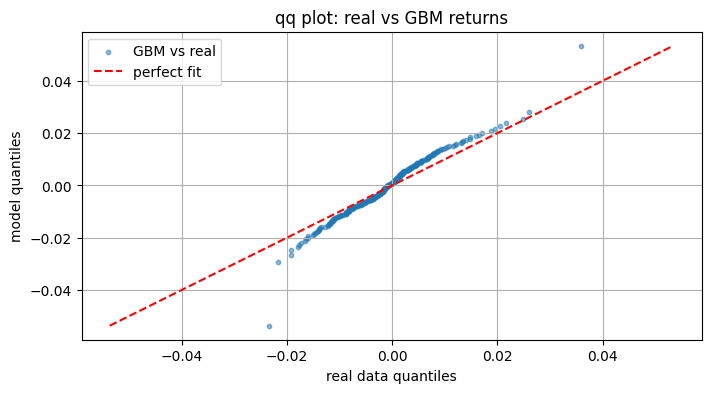

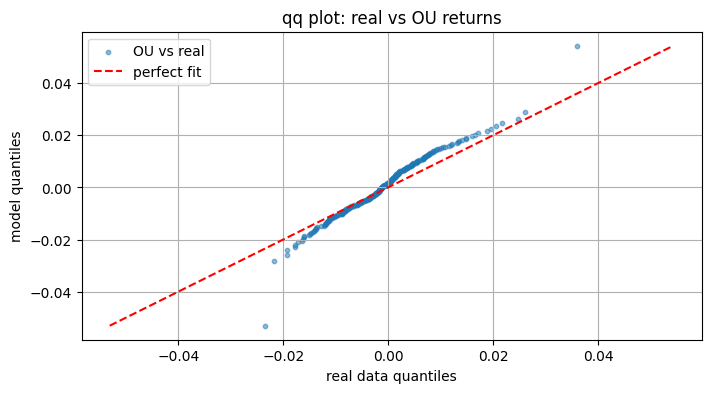

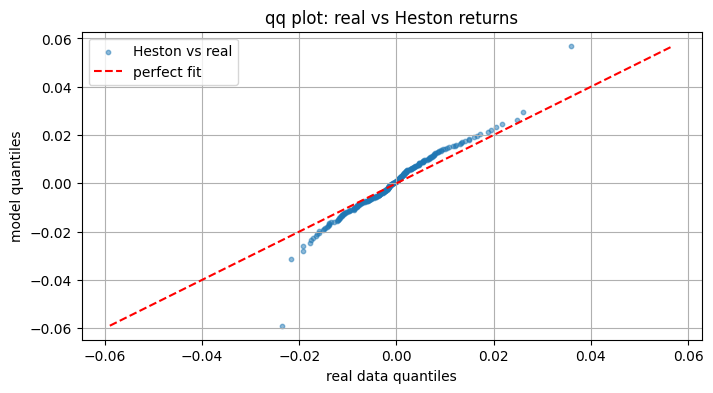

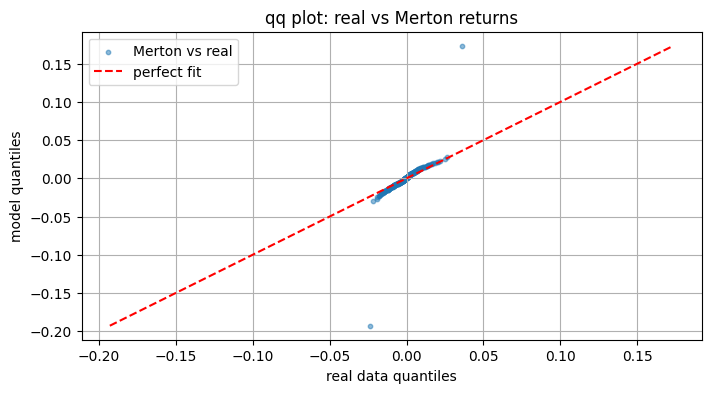

In [7]:
""" make QQ-plots to compare real returns vs simulated ones for each model """

qq_plot(log_returns_lastyear, log_ret_gbm,    "GBM",    "../plots/qq_gbm.png")
qq_plot(log_returns_lastyear, log_ret_ou,     "OU",     "../plots/qq_ou.png")
qq_plot(log_returns_lastyear, log_ret_heston, "Heston", "../plots/qq_heston.png")
qq_plot(log_returns_lastyear, log_ret_merton, "Merton", "../plots/qq_merton.png")


In [8]:
""" compare tail risk across models 
(e.g. "how often do models produce events worse than -3 sigmas?") """

def zscore(r):
    """ convert returns into standardized returns (z-scores) using the empirical mean and volatility of 
    real returns, so that tail probabilities are measured in units of real-market standard deviations """
    mu_real    = np.mean(log_returns_lastyear)
    sigma_real = np.std(log_returns_lastyear, ddof=1)
    r = np.asarray(r)
    return (r - mu_real) / sigma_real

z_real    = zscore(log_returns_lastyear)
z_gbm     = zscore(log_ret_gbm)
z_ou      = zscore(log_ret_ou)
z_heston  = zscore(log_ret_heston)
z_merton  = zscore(log_ret_merton)

def left_tail_prob(z, k):
    """ compute tail probability function P(z < -k)"""
    z = np.asarray(z)
    return np.mean(z < -k)   # relative frequency of z < -k

ks = [2, 3, 4] # 2sigma, 3sigma, 4sigma events

models_z = {
    "Real":   z_real,
    "GBM":    z_gbm,
    "OU":     z_ou,
    "Heston": z_heston,
    "Merton": z_merton,
}

rows = []
for k in ks:
    row = {"k": k}
    for name, z in models_z.items():
        row[name] = left_tail_prob(z, k)   # P(z < -k) for that model
    rows.append(row)

df_tail = pd.DataFrame(rows)
df_tail

,k,Real,GBM,OU,Heston,Merton
0,2,0.015873,0.049063,0.042188,0.052006,0.046422
1,3,0.000000,0.006849,0.005532,0.009530,0.006904
2,4,0.000000,0.000514,0.000427,0.001417,0.001096


In [9]:
""" make table for VaR and ES for confidence level alpha = 95% and 99% """

alphas = [0.95, 0.99]

models_r = {
    "Real":   log_returns_lastyear,
    "GBM":    log_ret_gbm,
    "OU":     log_ret_ou,
    "Heston": log_ret_heston,
    "Merton": log_ret_merton,
}

rows = []
for alpha in alphas:
    row = {"alpha": alpha}

    for name, r in models_r.items():
        row[f"VaR_{name}"] = get_var(r, alpha)

    for name, r in models_r.items():
        row[f"ES_{name}"]  = get_es(r, alpha)
    
    rows.append(row)

df_var = pd.DataFrame(rows)
df_var


,alpha,VaR_Real,VaR_GBM,VaR_OU,VaR_Heston,VaR_Merton,ES_Real,ES_GBM,ES_OU,ES_Heston,ES_Merton
0,0.95,0.014782,0.018320,0.017573,0.018644,0.018055,0.017785,0.022786,0.022029,0.023760,0.023048
1,0.99,0.019280,0.025629,0.024864,0.026907,0.025585,0.021523,0.029259,0.028501,0.031474,0.031468


In [10]:
# if we prefer to read directly in percentages: 
df_var_pct = df_var.copy()
for col in df_var_pct.columns:
    if col == "alpha":
        continue
    df_var_pct[col] = (df_var_pct[col] * 100).round(3)

df_var_pct


,alpha,VaR_Real,VaR_GBM,VaR_OU,VaR_Heston,VaR_Merton,ES_Real,ES_GBM,ES_OU,ES_Heston,ES_Merton
0,0.95,1.478,1.832,1.757,1.864,1.806,1.779,2.279,2.203,2.376,2.305
1,0.99,1.928,2.563,2.486,2.691,2.559,2.152,2.926,2.850,3.147,3.147
